In [234]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform as uniform

plt.rcParams["figure.figsize"] = (25,8)

# mackey glass

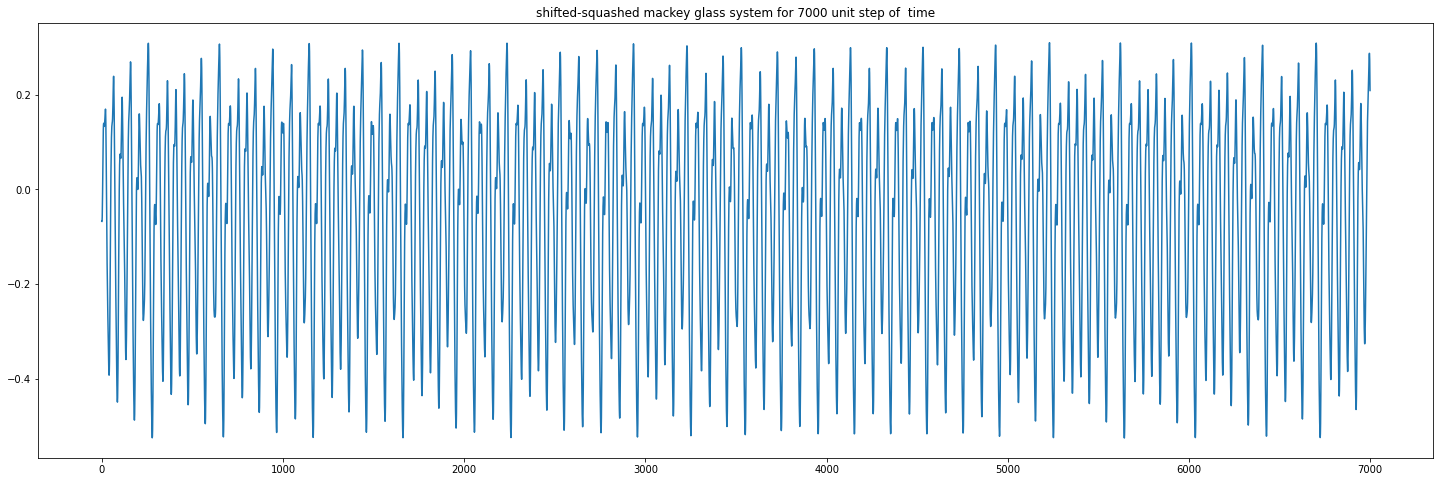

In [235]:
alpha = 0.2 
beta = 10 
gamma = 0.1 
tha = 17
delta = 0.1

initialTransition = 10000
time = 7000 + initialTransition

y = uniform(0 , 1 ,size = int((time/delta))) 

for i in range(len(y)):
  y [i] = y [i-1] + delta * ( ((alpha * y[int(i-tha/delta)]) / (1+y[int(i-tha/delta)]**beta)) - gamma*y[i-1] )

mackey = np.tanh(y[::int(1/delta)][initialTransition:] - 1)

plt.title('shifted-squashed mackey glass system for {} unit step of  time'.format(time - initialTransition))
plt.plot(np.arange(len(mackey)), mackey )
plt.show()

time = time - initialTransition  # for future use 

In [236]:
lenght_sequence = 4000
lag_between_input_output = 60
test_size = 500  

# input_  = mackey [:lenght_sequence] .reshape((-1,1))
input_ =  np.ones((lenght_sequence , 1)) 
# test_input_ = mackey [:lenght_sequence*test_coef] .reshape((-1,1))
test_input_ =  np.ones((lenght_sequence+ test_size , 1)) 

output_ = mackey [lag_between_input_output : lenght_sequence+lag_between_input_output].reshape((-1,1))
test_output_ = mackey [lag_between_input_output : test_size+lenght_sequence+lag_between_input_output].reshape((-1,1))


print('shape input = ', input_.shape)
print('shape output = ', output_.shape)
print('shape test input = ', test_input_.shape)
print('shape test output = ', test_output_.shape)

shape input =  (4000, 1)
shape output =  (4000, 1)
shape test input =  (4500, 1)
shape test output =  (4500, 1)


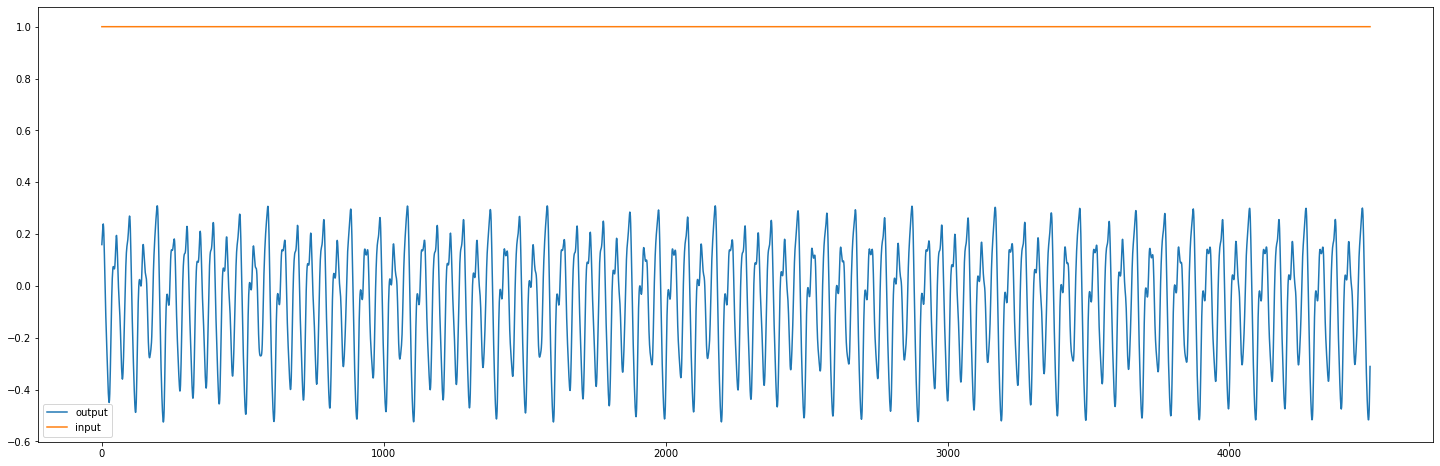

In [237]:
plt.plot(np.arange(test_output_.shape[0]),test_output_ , label = 'output')
plt.plot(np.arange(test_output_.shape[0]),test_input_ , label = 'input')
plt.legend()
plt.show()

# model

In [238]:
input_dim = input_.shape[1]
output_dim = output_.shape[1]
num_reservoir = 1000

singular_value_coef = 0.85

max_w_in = 0.001
max_w_back = 0.9

sparsity_percentage_w_in = 0.5
sparsity_percentage_w_back = 0.5
sparsity_percentage_reservoir  = 0.9

w_in = uniform(low = - max_w_in , high = max_w_in , size =(input_dim,num_reservoir)) 
w_in[uniform(low = 0 , high = 1 , size =w_in.shape)  < sparsity_percentage_w_in ] = 0

w    = uniform(low = - 1 , high = 1 , size =(num_reservoir,num_reservoir))  
w[uniform(low = 0 , high = 1 , size =w.shape)  < sparsity_percentage_reservoir] = 0
w = w / (singular_value_coef *max(np.linalg.svd(w)[1]))

w_back = uniform(low = -max_w_back , high = max_w_back , size =(output_dim,num_reservoir))   
w_back [uniform(low = 0 , high = 1 , size =w_back.shape)  < sparsity_percentage_w_back] = 0

w_readout = uniform(low = -1 , high = 1 , size =(num_reservoir,output_dim) )

In [239]:
time_constant = 1
leak_rate     = 0.6

maximum_singular_value = max(np.linalg.svd(w)[1])   
print('\n weight matrix biggest singular value =',maximum_singular_value)
# print('\n in leaky integrator case effective singular value =' ,abs(1 - (1/time_constant)*(leak_rate-maximum_singular_value)) )


 weight matrix biggest singular value = 1.1764705882352944


In [246]:
noise_maximum_value =  1e-5

def noise(low = -noise_maximum_value , high =noise_maximum_value , size =(1,num_reservoir))  : 
  return uniform(low = -noise_maximum_value , high =noise_maximum_value , size =(1,num_reservoir)) 
  

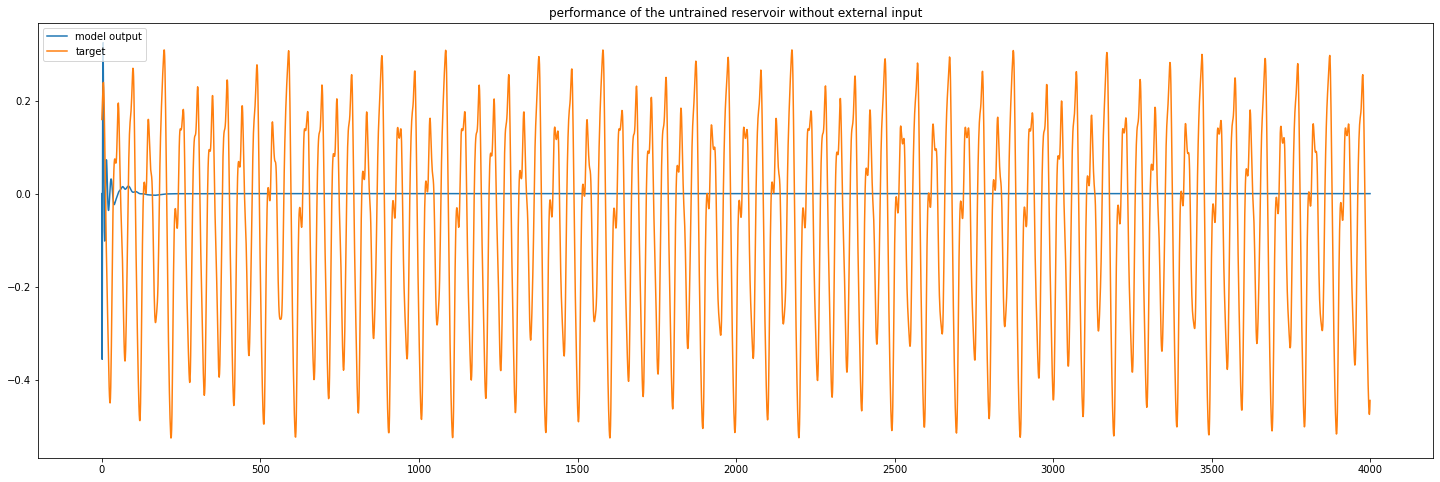

In [259]:
trainsize = len(input_)  #trainsize is to denote how much of data to use to train the model

X = uniform(-1 , 1 , size = (trainsize,num_reservoir)) 
preds = np.zeros((trainsize,1))

for step in range(1,trainsize) : 
  dx = (- leak_rate * X[[step-1]] + np.tanh(X[[step-1]] @ w  )) / time_constant
  X[[step]] = X[[step-1]] + dx 
  preds [step] = X[[step]] @ w_readout

plt.plot(np.arange(trainsize), preds , label='model output' )
plt.plot(np.arange(trainsize), output_ , label= 'target')
plt.title('performance of the untrained reservoir without external input')
plt.legend()
plt.show()

In [248]:
trainsize = len(input_)  #trainsize is to denote how much of data to use to train the model

# np.random.seed(4)
X = uniform(-0.01 , 0.01 , size = (trainsize,num_reservoir)) 
# X = np.zeros( (trainsize,num_reservoir)) 

for step in range(1,trainsize) : 
  dx = (- leak_rate * X[[step-1]] + np.tanh(X[[step-1]] @ w + input_[[step]] @ w_in + output_[[step-1]] @ w_back + noise() )) / time_constant
  X[[step]] = X[[step-1]] + dx 


In [249]:
discard = 1000
regularization_coef = 0.0001
print('number of initial states to discard in learning the redout weights =',discard)

w_readout = np.linalg.inv(X[discard :].T @ X[discard :] + regularization_coef * np.identity(num_reservoir)) @ X[discard :].T @ output_[discard :trainsize]

number of initial states to discard in learning the redout weights = 1000


In [252]:
test_len = len(test_input_)
preds = np.zeros((test_len,1))

# np.random.seed(4)
X = uniform(-0.01 , 0.01 , size = (test_len,num_reservoir)) 
# X = np.zeros( (test_len,num_reservoir) )
teacher_startup =  discard * 2

for step in range(1,test_len):
    if step < teacher_startup  : 
      dx = (- leak_rate * X[[step-1]] + np.tanh(X[[step-1]] @ w + test_input_[[step]] @ w_in + test_output_[[step-1]] @ w_back +
      uniform(low = -noise_maximum_value , high =noise_maximum_value , size =(1,num_reservoir)))) / time_constant
      X[[step]] = X[[step-1]] + dx 
      preds [step] = X[[step]] @ w_readout
    
    else :  
      dx = (- leak_rate * X[[step-1]] + np.tanh(X[[step-1]] @ w + test_input_[[step]] @ w_in + preds[[step-1]] @ w_back + 
            uniform(low = -noise_maximum_value , high =noise_maximum_value , size =(1,num_reservoir)))) / time_constant
      X[[step]] = X[[step-1]] + dx 
      preds [step] = X[[step]] @ w_readout

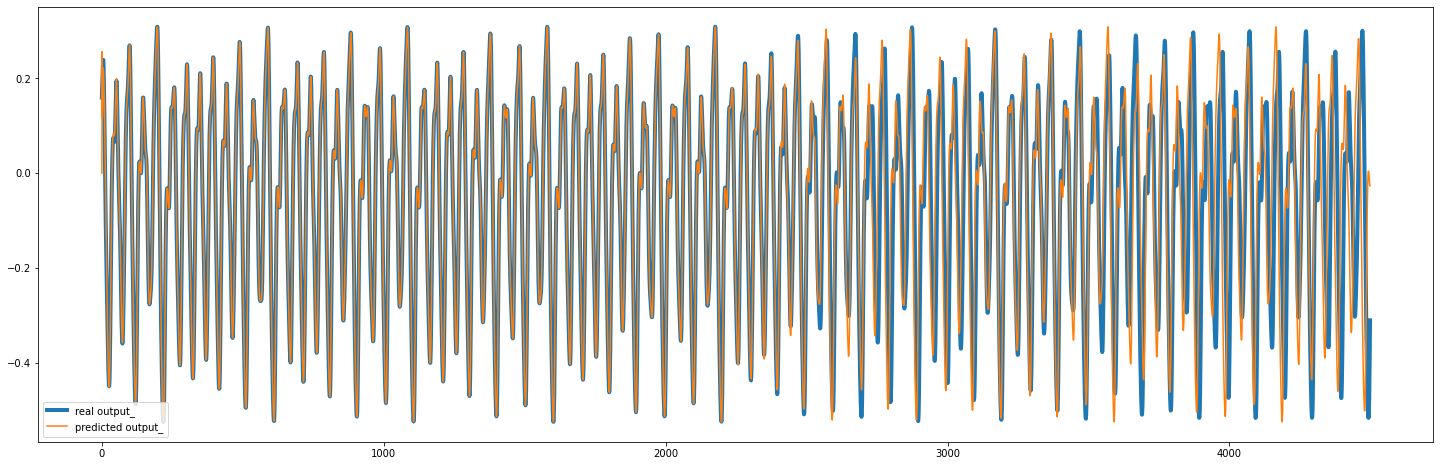


length train = 4000 , length test = 500 

rmse train =  0.09695805285108289
rmse test =  0.24740651717666073


In [253]:
from_step  = 0 # discard 
to_step = test_len
time = len(test_input_)

plt.plot(np.arange(time)[from_step :to_step],test_output_[from_step :to_step] , label = 'real output_' , linewidth = '4')
plt.plot(np.arange(time)[from_step :to_step],preds[from_step :to_step], label = 'predicted output_' )
plt.legend()  
plt.show()    

print('\nlength train = {} , length test = {} \n'.format(trainsize, test_size))
print('rmse train = ', (np.sum((preds[:trainsize] - test_output_[:trainsize] )**2) /trainsize)**0.5 ) 
print('rmse test = ', (np.sum(np.abs(preds[trainsize:] - test_output_[trainsize:] )**2) / (time-trainsize))**0.5 )